In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pyccl as ccl
from scipy.optimize import minimize
import emcee
import astropy.cosmology
import astropy.units as u
from chainconsumer import ChainConsumer
import pickle
import pandas as pd
import sacc
from scipy.stats import norm
from numpy.random import normal
from helper_functions import *
import astropy.table

# IF MAKING FINAL PLOTS:
# plt.rc("text", usetex=True)
# plt.rc("font", family="serif")
# ELSE:
# plt.rc("text", usetex=False)
# plt.rc("font", family="sans")
# plt.rc("font", sans-serif="Times")
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Times"]
})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
# %matplotlib inline
plt.rcParams.update({'font.size':14})


# Load data

In [2]:
with open('pz_Nz_Y1.pkl', 'rb') as f:
    nz_pz_in = pickle.load(f)

In [3]:
# Load in skysim_all:
skysim_all_data = pd.DataFrame()
covlist_skysim = []
nz_df = pd.DataFrame()
zmin=0.2
for i in range(5):
    zmax=zmin+.2
    tab = astropy.table.Table.read(f'skysim5000/w_skysim_all_24p1/w_skysim5000_{zmin:.1f}_{zmax:.1f}_lt24p1_all_norsd.fits.gz')
    skysim_all_data[f'theta_{i}'] = tab['theta'].byteswap().newbyteorder()
    skysim_all_data[f'w_{i}'] = tab['w'].byteswap().newbyteorder()
    skysim_all_data[f'werr_{i}'] = tab['w_err'].byteswap().newbyteorder()
    nz_tab = astropy.table.Table.read(f'skysim5000/w_skysim_all_24p1/dndz_skysim5000_{zmin:.1f}_{zmax:.1f}_lt24p1_all_norsd.fits.gz')
    nz_df[f'z_{i}'] = nz_tab['z'].byteswap().newbyteorder()
    nz_df[f'Nz_{i}'] = nz_tab['dndz'].byteswap().newbyteorder()
    covlist_skysim.append(np.load(f'skysim5000/w_skysim_all_24p1/skysim_{0.2+0.2*i:.1f}_{0.4+0.2*i:.1f}_lt24p1_all_cov_norsd.npy'))
    # print(f'skysim5000/w_skysim_all_24p1/w_skysim5000_{zmin:.1f}_{zmax:.1f}_lt24p1_all_norsd.fits.gz')
    zmin+=.2

In [4]:
skysim_area = np.pi / 2 * 3282.8 # <- 1 steradian
dc2_area = 294.16
print(skysim_area/dc2_area)

# Load in DC2
wtheta = astropy.table.Table.read('DC2_DR6_wtheta_09_03_2024_Y1_photz.fits.gz')
nz, dndz = np.load('DC2_DR6_Nz_2_29_2024_5bin.npy', allow_pickle=True)
# nz, dndz = np.load('DC2_DR6_Nz_09_03_2024_Y1_photz.npy', allow_pickle=True)
covlist = np.array(covlist_skysim)*(skysim_area/dc2_area)

17.52995030460391


In [5]:
df_dict = {}
nz_dict = {}
for key in nz.keys():
    df_list = []
    nz_list = []
    for i in range(5):
        nz_list.append(pd.DataFrame([nz[key][i], dndz[key][i]])
            .rename(index={0: f"Nz_{i}", 1: f"z_{i}"})
            .T
        )
        if 'true' in key:
            df_list.append(pd.DataFrame([wtheta[f'theta_{key}_{i}'], wtheta[f'w_{key}_{i}'], wtheta[f'w_err_{key}_{i}']])
            .rename(index={0: f"theta_{i}", 1: f"w_{i}", 2: f"werr_{i}"})
            .T)
        elif '1t1' in key:
            df_list.append(pd.DataFrame([wtheta[f'theta_obs_1to1_{i}'], wtheta[f'w_obs_1to1_{i}'], wtheta[f'w_err_obs_1to1_{i}']])
            .rename(index={0: f"theta_{i}", 1: f"w_{i}", 2: f"werr_{i}"})
            .T)
        elif 'mtm' in key:
            df_list.append(pd.DataFrame([wtheta[f'theta_obs_manytomany_{i}'], wtheta[f'w_obs_manytomany_{i}'], wtheta[f'w_err_obs_manytomany_{i}']])
            .rename(index={0: f"theta_{i}", 1: f"w_{i}", 2: f"werr_{i}"})
            .T)
        elif 'meas_other' in key:
            df_list.append(pd.DataFrame([wtheta[f'theta_obs_other_{i}'], wtheta[f'w_obs_other_{i}'], wtheta[f'w_err_obs_other_{i}']])
            .rename(index={0: f"theta_{i}", 1: f"w_{i}", 2: f"werr_{i}"})
            .T)
        elif 'artifact' in key:
            df_list.append(pd.DataFrame([wtheta[f'theta_{key}_{i}'], wtheta[f'w_{key}_{i}'], wtheta[f'w_err_{key}_{i}']])
            .rename(index={0: f"theta_{i}", 1: f"w_{i}", 2: f"werr_{i}"})
            .T)
        else:
            df_list.append(pd.DataFrame([wtheta[f'theta_obs_{key}_{i}'], wtheta[f'w_obs_{key}_{i}'], wtheta[f'w_err_obs_{key}_{i}']])
            .rename(index={0: f"theta_{i}", 1: f"w_{i}", 2: f"werr_{i}"})
            .T)
    df_dict[key] = pd.concat(df_list, axis=1)
    nz_dict[key] = pd.concat(nz_list, axis=1)

In [6]:
# Replace 1t1, mtm, all N(z):
for i in range(5):
    nz_dict['all'][f'Nz_{i}'] = nz_pz_in[f'nz_all_{i}']
    nz_dict['1t1'][f'Nz_{i}'] = nz_pz_in[f'nz_oto_{i}']
    nz_dict['mtm'][f'Nz_{i}'] = nz_pz_in[f'nz_otm_{i}']

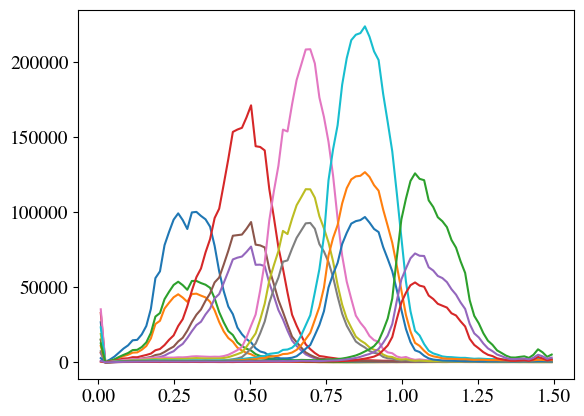

In [7]:
# Check N(z):
for i in range(5):
    plt.plot(nz_dict['all'][f'z_{i}'], nz_dict['all'][f'Nz_{i}'])
    plt.plot(nz_dict['1t1'][f'z_{i}'], nz_dict['1t1'][f'Nz_{i}'])
    plt.plot(nz_dict['mtm'][f'z_{i}'], nz_dict['mtm'][f'Nz_{i}'])
plt.show()

In [8]:
data_vector_list = {
    key: (df_dict[key], nz_dict[key], covlist) for key in df_dict.keys()
}

In [9]:
data_vector_skysim = (skysim_all_data, nz_df, covlist_skysim)

In [10]:
df_dict.keys()

dict_keys(['all', '1t1', 'mtm', 'meas_other', 'artifact', 'true_lost', 'true_all'])

In [11]:
keys_to_use = ['all', '1t1', 'mtm', 'true_all']

# Define Model

In [12]:
def model(pars, data, nz_out):
    Omega_m, b1, b2, b3, b4, b5 = pars
    b = np.array([b1, b2, b3, b4, b5,])
    cosmo = ccl.Cosmology(Omega_b=0.0448, Omega_c=Omega_m-0.0448, n_s=0.963, h=0.71, sigma8=0.8)
    return model_ccl_helper(data, b, nz_out, cosmo, has_rsd=False)

def prior(pars):
    Omega_m, b1, b2, b3, b4, b5 = pars
    if (0.1 < Omega_m < 0.9) & \
    (0 < b1 < 3) & \
    (0 < b2 < 3) & \
    (0 < b3 < 3) & \
    (0 < b4 < 3) & \
    (0 < b5 < 3):
        pr =  norm.pdf(Omega_m-0.0448, 0.22, 0.2) *\
        norm.pdf(b1, 1.9, 0.9) *\
        norm.pdf(b2, 1.9, 0.9) *\
        norm.pdf(b3, 1.9, 0.9) *\
        norm.pdf(b4, 1.9, 0.9) *\
        norm.pdf(b5, 1.9, 0.9)
    
        return np.log(pr) 
    else:
        return -np.inf

In [13]:
data_vector = data_vector_list['true_all']
angle_list = compute_scale_cuts(8500)
txp_angles = [42.81, 26.93, 20.21, 16.52, 14.21]
parnames = ['$\\Omega_m$', '$b_1$', '$b_2$', '$b_3$', '$b_4$', '$b_5$',]
masks, inv_cov = preprocess(data_vector, angle_list)
tarr = [0.265, 1.229, 1.362, 1.502, 1.648, 1.799]  
print(log_like(tarr, data_vector[0], data_vector[1], inv_cov, masks, model, prior))

-276.37940780070886


In [14]:
masks, inv_cov = preprocess(data_vector_skysim, angle_list) 
print(log_like(tarr, data_vector_skysim[0], data_vector_skysim[1], inv_cov, masks, model, prior))

-4670.02589743618


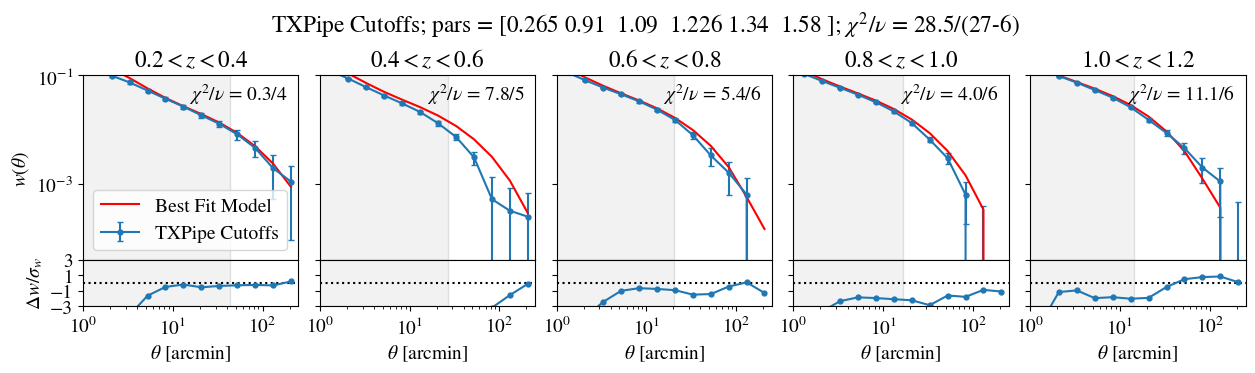

In [15]:
parr = [0.265, 0.91, 1.09, 1.226, 1.34, 1.58]  
plot_model_residual(data_vector, None, model, 'TXPipe Cutoffs', txp_angles, 
                    parnames, fit_vals=parr, color='C0', use_cov=False, resid_limits=(-3, 3), delta_or_ratio='delta', yticks=[-3,-1,1,3])

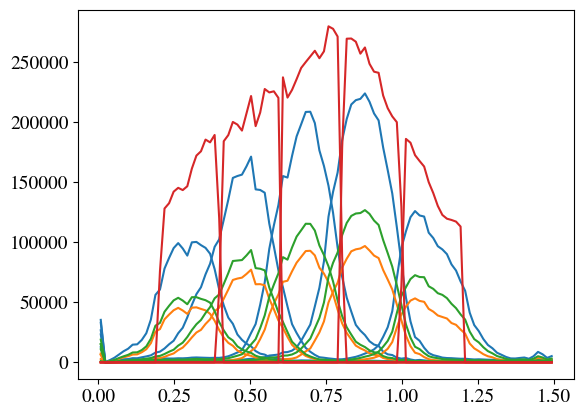

In [16]:
for j, key in enumerate(keys_to_use):
    for i in range(5):
        plt.plot(data_vector_list[key][1][f'z_{i}'], data_vector_list[key][1][f'Nz_{i}'], color=f'C{j}', label=key)

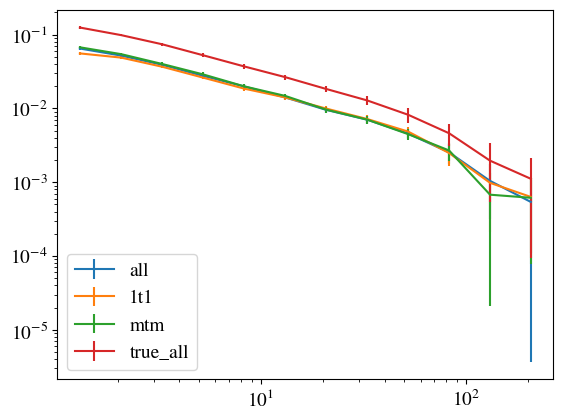

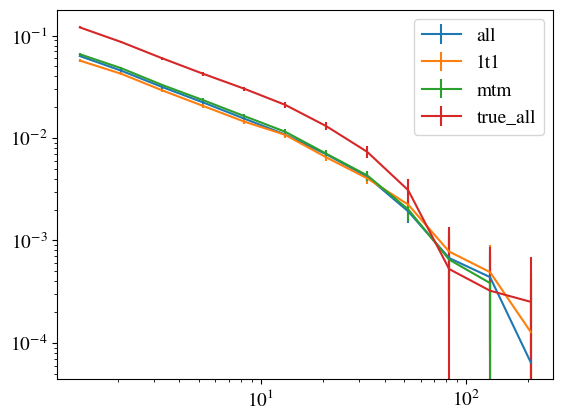

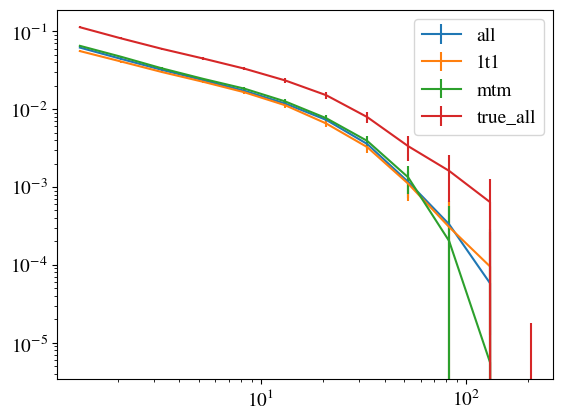

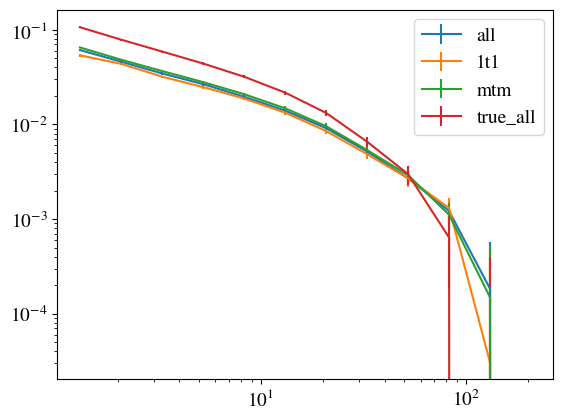

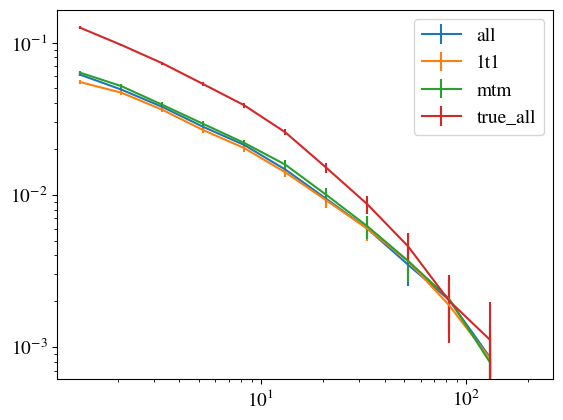

In [17]:
for i in range(5):
    for j, key in enumerate(keys_to_use):
        plt.errorbar(data_vector_list[key][0][f'theta_{i}'], 
                     data_vector_list[key][0][f'w_{i}'],
                     data_vector_list[key][0][f'werr_{i}'], color=f'C{j}', label=key)
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.show()

# Run Chains

In [21]:
for key in keys_to_use[:3]:
    print(key)
    res = gradient_minimize(tarr, data_vector_list[key], txp_angles, model, prior)
    run_emcee(data_vector_list[key], f'final_samples/chain_dc2_skysimjk_txpcut_Y1photz_{key}_Oct19', res.x, txp_angles, model, prior, nsteps=1000)
# print('Skysim')
# res = gradient_minimize(tarr, data_vector_skysim, txp_angles, model, prior)
# run_emcee(data_vector_skysim, f'final_samples/chain_skysim5000_skysimjk_txpcut_Aug3', res.x, txp_angles, model, prior, nsteps=1000)

all


100%|██████████| 1000/1000 [3:02:06<00:00, 10.93s/it] 


1t1


100%|██████████| 1000/1000 [3:10:01<00:00, 11.40s/it] 


mtm


100%|██████████| 1000/1000 [3:07:18<00:00, 11.24s/it] 


# Plots and Analysis

In [18]:
chain_list = []
for key in keys_to_use:
    chain_list.append(np.load(f'final_samples/chain_dc2_skysimjk_txpcut_{key}_Mar1.npy'))
chain_list.append(np.load('final_samples/chain_skysim5000_skysimjk_txpcut_Aug3.npy'))
chain_list = np.array(chain_list)

parnames = ['$\\Omega_m$', '$b_1$', '$b_2$', '$b_3$', '$b_4$', '$b_5$',]

In [19]:
len(chain_list[0])

32000

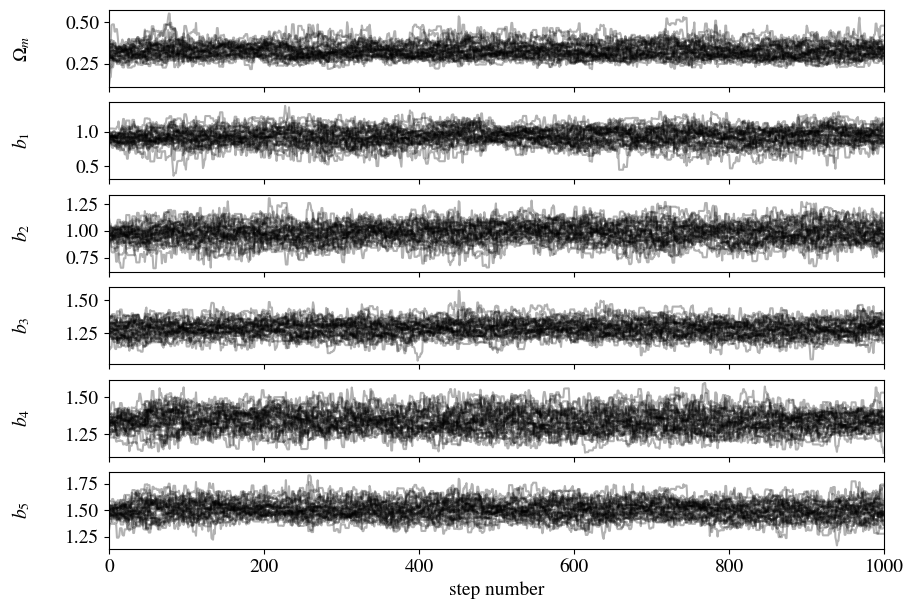

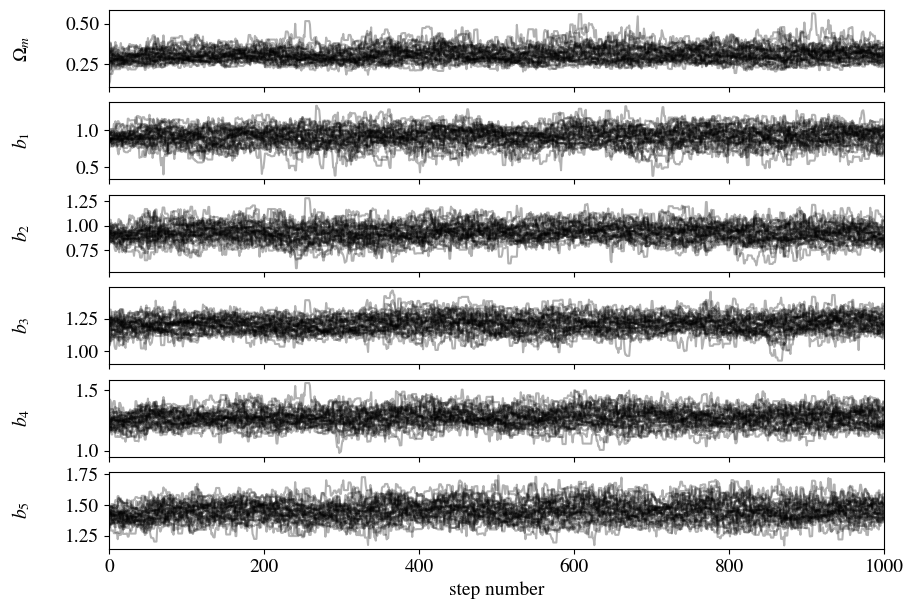

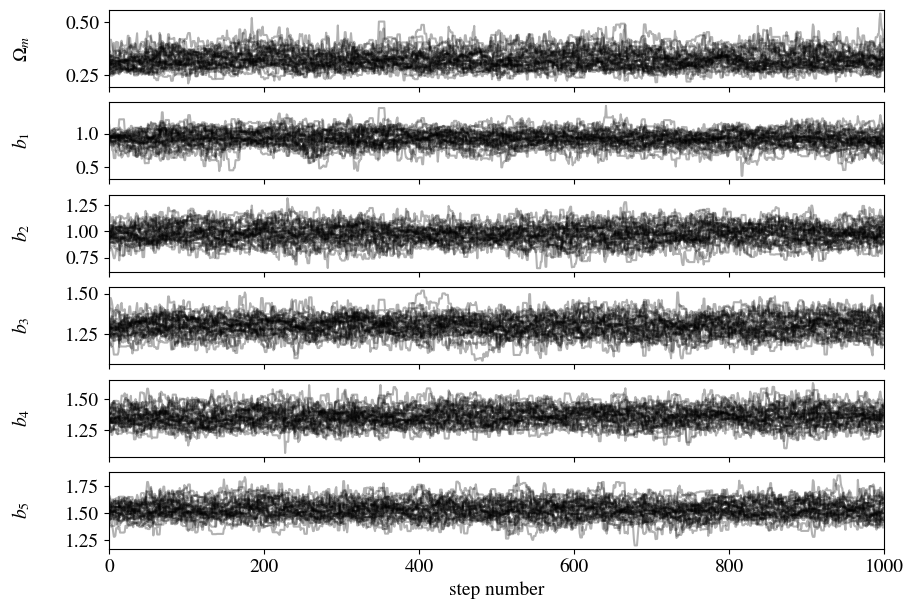

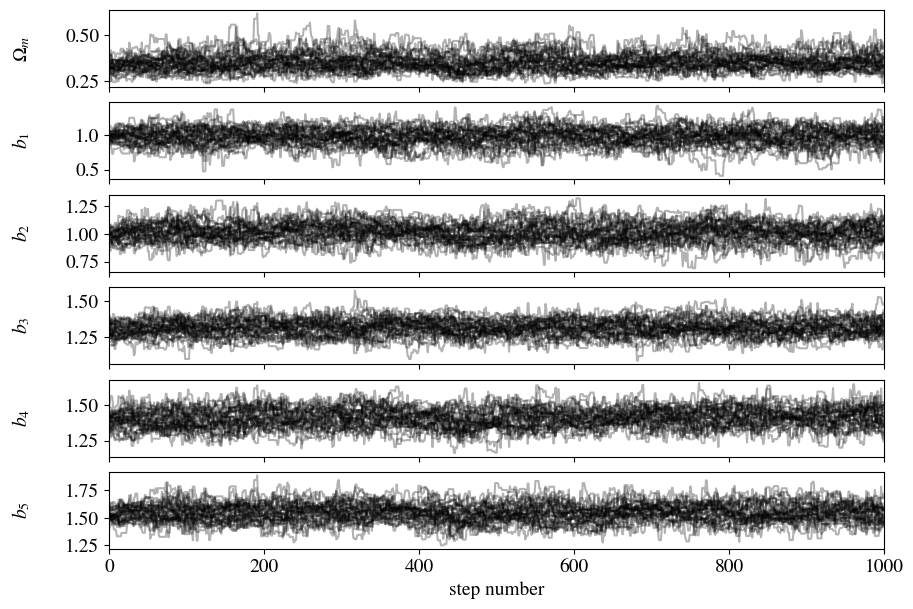

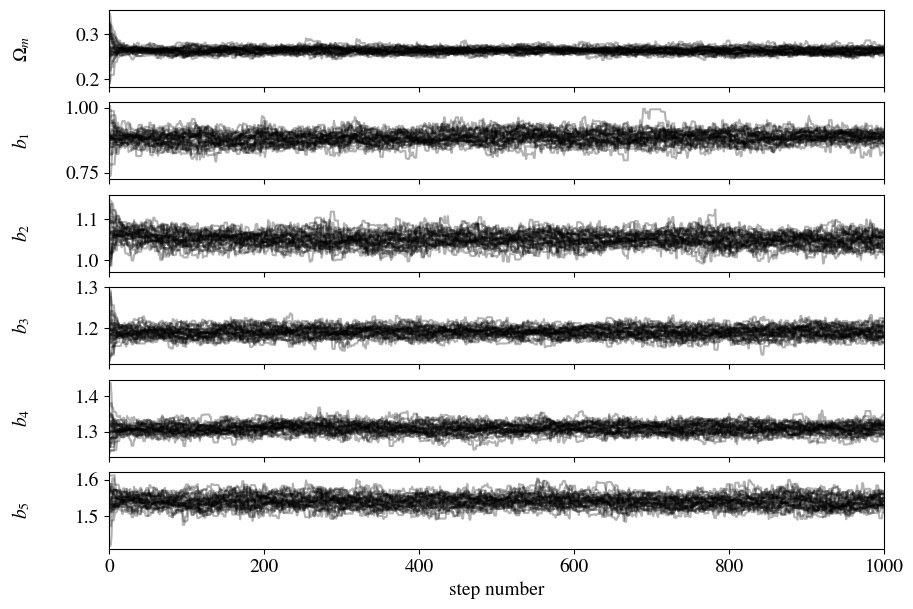

In [20]:
plot_convergence(chain_list, parnames)

In [21]:
chain_trimmed = []
for i in chain_list:
    chain_trimmed.append(process_stuck_chain(i, 100))
chain_trimmed = np.array(chain_trimmed)

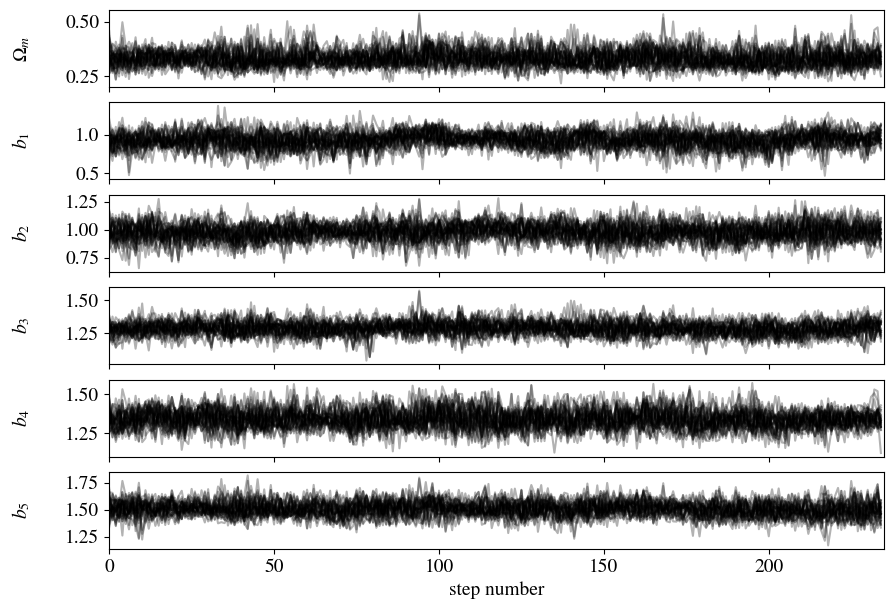

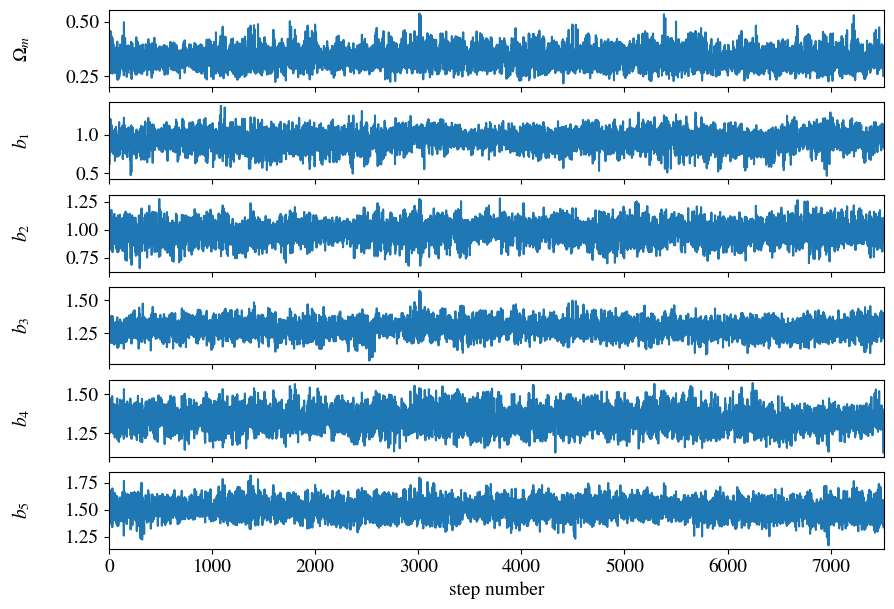

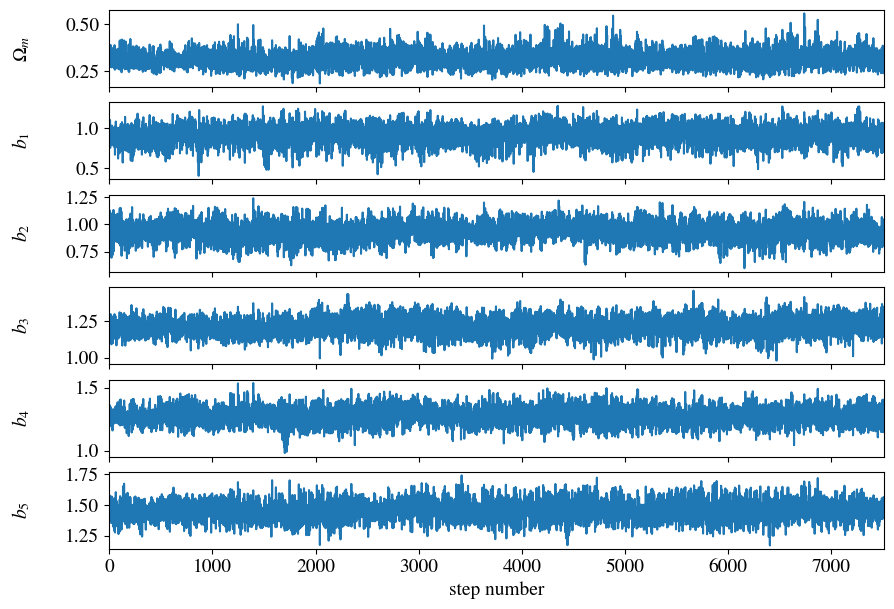

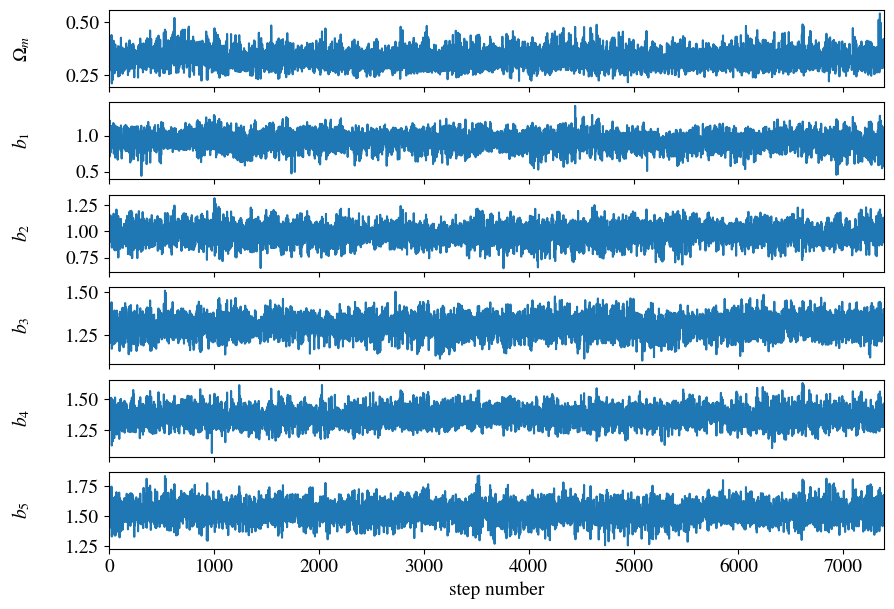

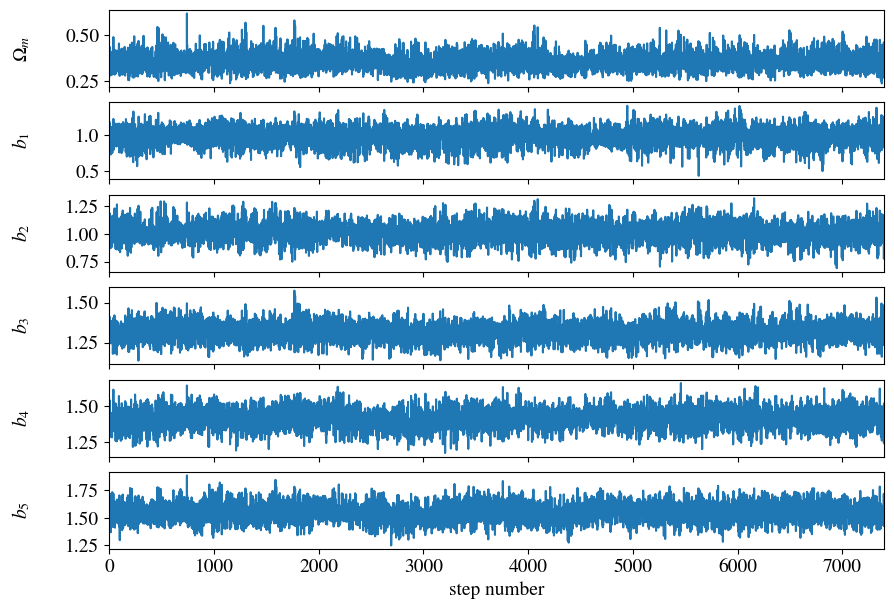

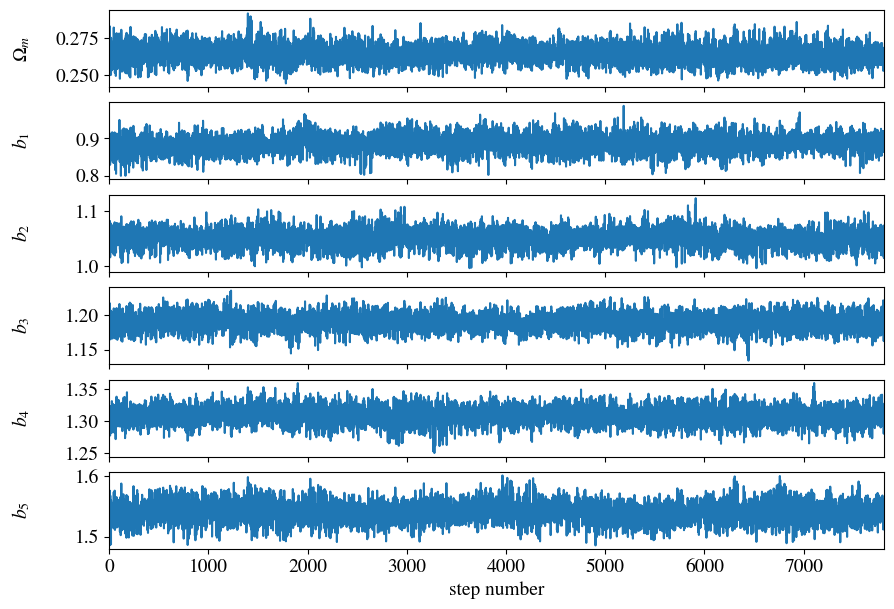

In [22]:
plot_convergence(chain_trimmed, parnames)

In [23]:
prior_list = np.array([normal(0.22+0.0448, 0.2, size=100000),
                       normal(1.229, 0.9, size=100000),
                       normal(1.362, 0.9, size=100000),
                       normal(1.502, 0.9, size=100000),
                       normal(1.648, 0.9, size=100000),
                       normal(1.799, 0.9, size=100000),])

In [24]:
for key in keys_to_use:
    print(key)

all
1t1
mtm
true_all


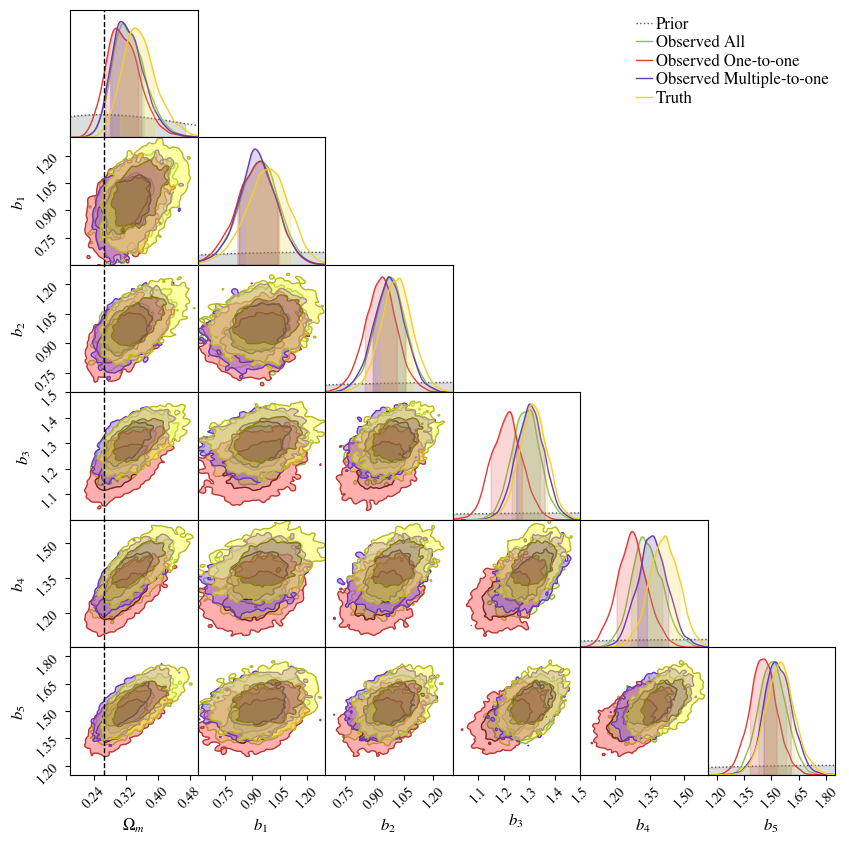

In [25]:
c = ChainConsumer()
names = ['Observed All', 'Observed One-to-one', 'Observed Multiple-to-one', 'Truth',]
# colors = ["#FF7F0E", "#1F77B4"]

c.add_chain(prior_list.T, parameters=parnames, name="Prior", show_as_1d_prior=True, color="#535A5B")

for i in range(len(names)):
    # c.add_chain(chain_trimmed[i], parameters=parnames, name=names[i], color=colors[i])
    c.add_chain(chain_trimmed[i], parameters=parnames, name=names[i])

c.configure(usetex=False, shade=True, bar_shade=True, legend_color_text=False, linestyles=[":", "-", "-", "-", "-"])
# c.configure(usetex=False, shade=True, bar_shade=True, kde=True)
c.plotter.plot(truth=[0.265, ],
                    #   0.86650961, 1.06271354, 1.18494648, 1.30541203, 1.55081382],
               extents={"$\Omega_m$": (.18,.5),
                        "$b_1$": (.6,1.3),
                        "$b_2$": (0.65,1.3),
                        "$b_3$": (1.0,1.5),
                        "$b_4$": (1.05,1.6),
                        "$b_5$": (1.15,1.85),
                       });


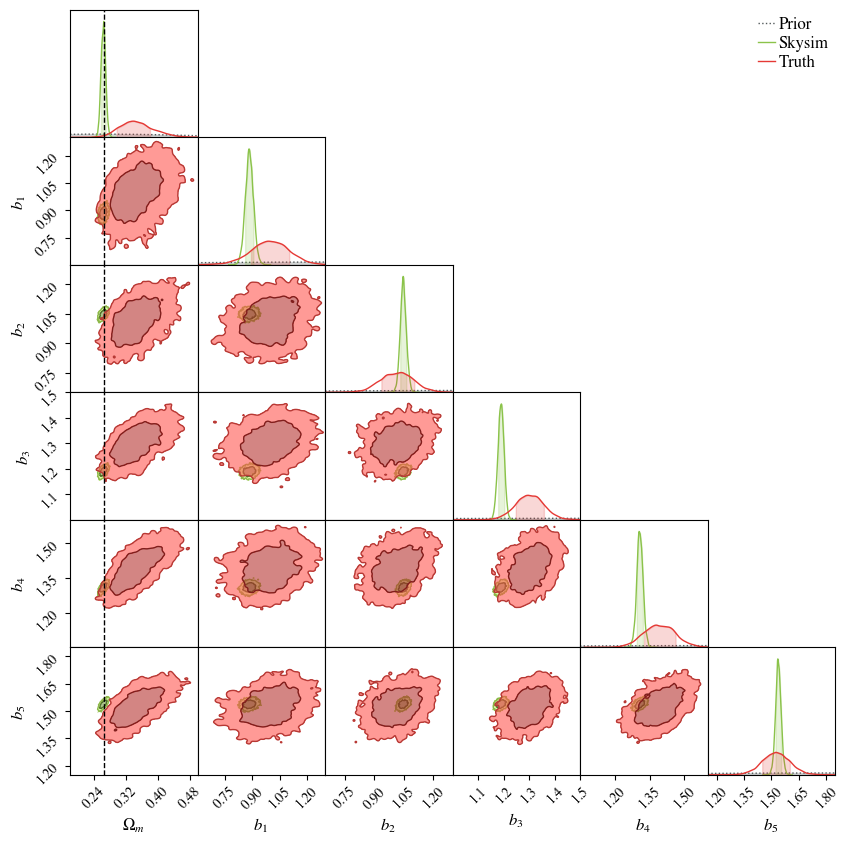

In [ ]:
c = ChainConsumer()
names = ['Skysim', 'Truth',]
# colors = ["#FF7F0E", "#1F77B4"]

c.add_chain(prior_list.T, parameters=parnames, name="Prior", show_as_1d_prior=True, color="#535A5B")

c.add_chain(chain_trimmed[4], parameters=parnames, name=names[0])
c.add_chain(chain_trimmed[3], parameters=parnames, name=names[1])

c.configure(usetex=False, shade=True, bar_shade=True, legend_color_text=False, linestyles=[":", "-", "-", "-", "-"])
# c.configure(usetex=False, shade=True, bar_shade=True, kde=True)
c.plotter.plot(truth=[0.265, ],
                    #   0.86650961, 1.06271354, 1.18494648, 1.30541203, 1.55081382],
               extents={"$\Omega_m$": (.18,.5),
                        "$b_1$": (.6,1.3),
                        "$b_2$": (0.65,1.3),
                        "$b_3$": (1.0,1.5),
                        "$b_4$": (1.05,1.6),
                        "$b_5$": (1.15,1.85),
                       });


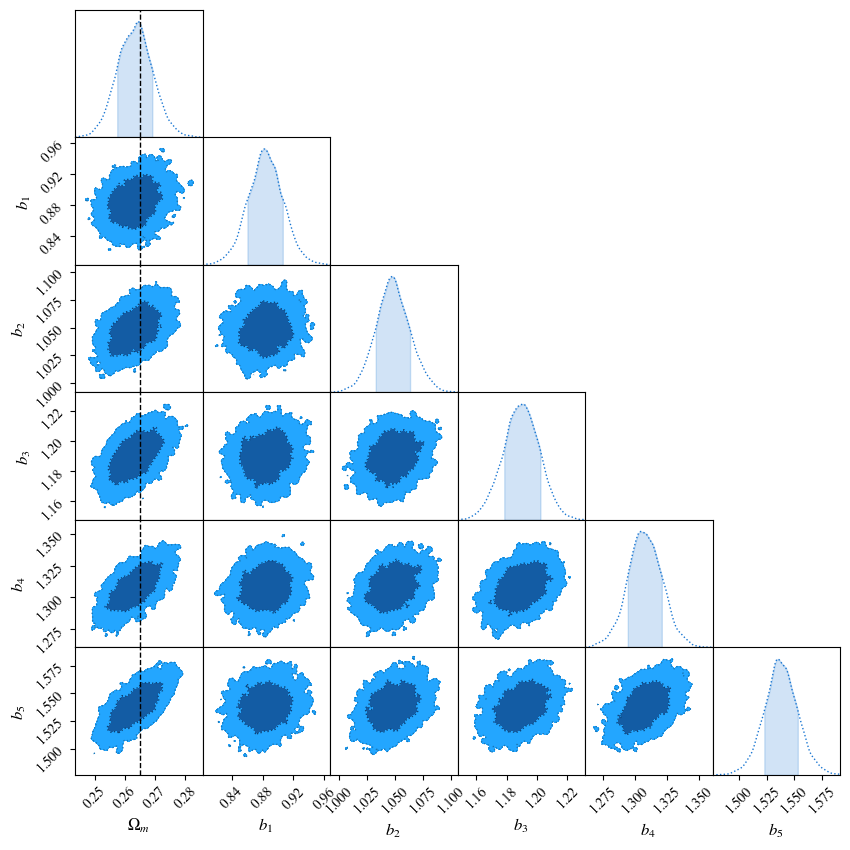

In [ ]:
c = ChainConsumer()
names = ['Skysim', 'Truth',]
# colors = ["#FF7F0E", "#1F77B4"]

# c.add_chain(prior_list.T, parameters=parnames, name="Prior", show_as_1d_prior=True, color="#535A5B")

c.add_chain(chain_trimmed[4], parameters=parnames, name=names[0])
# c.add_chain(chain_trimmed[3], parameters=parnames, name=names[1])

c.configure(usetex=False, shade=True, bar_shade=True, legend_color_text=False, linestyles=[":", "-", "-", "-", "-"])
# c.configure(usetex=False, shade=True, bar_shade=True, kde=True)
c.plotter.plot(truth=[0.265, ],);


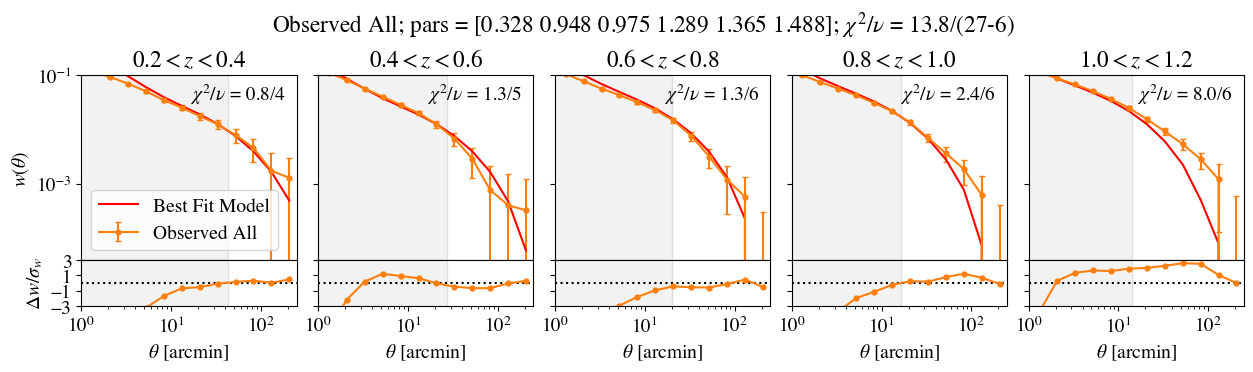

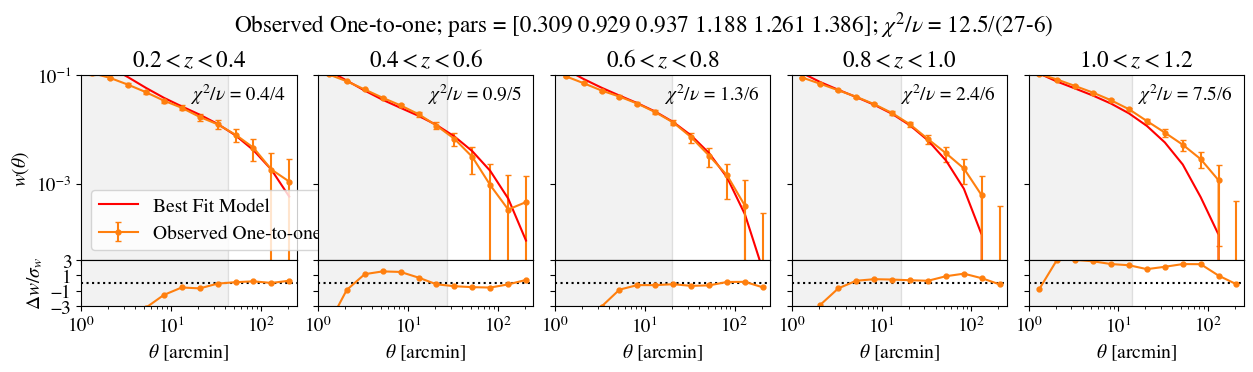

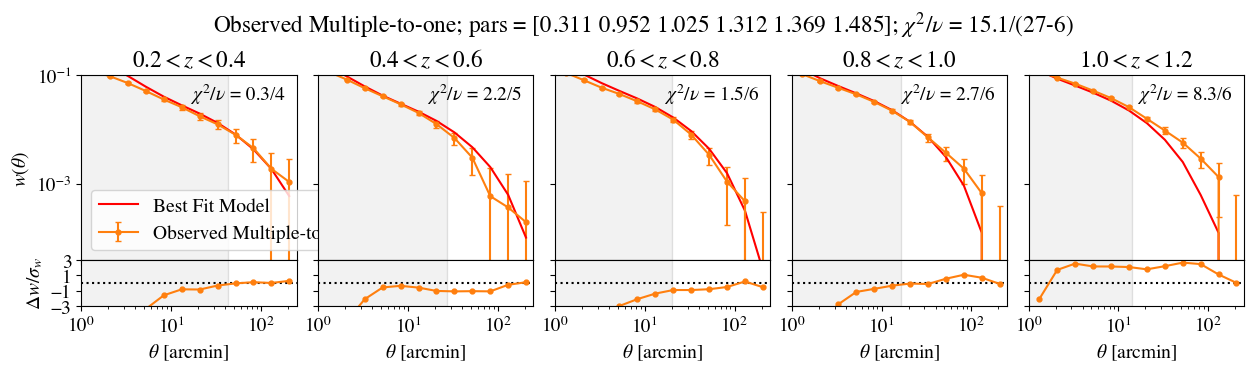

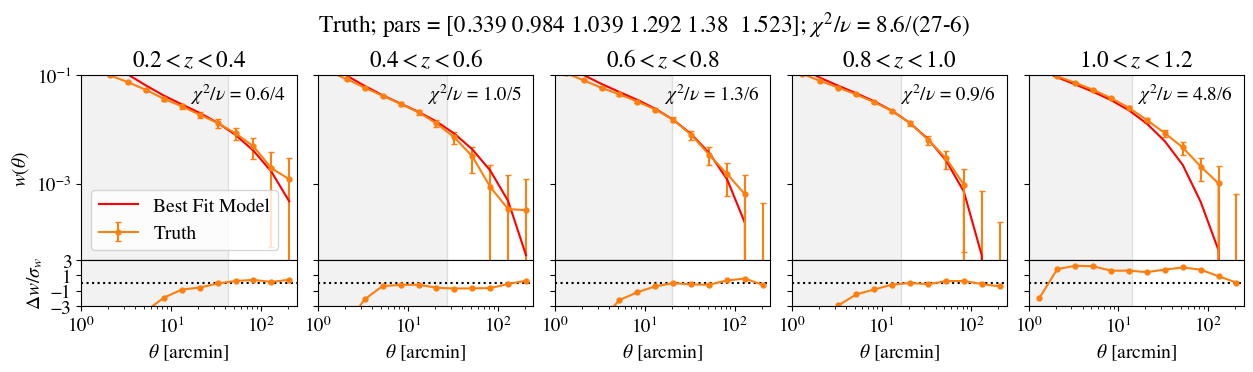

IndexError: list index out of range

In [ ]:
names = ['Observed All', 'Observed One-to-one', 'Observed Multiple-to-one', 'Truth',]
for i in range(len(chain_trimmed)):
    plot_model_residual(data_vector_list[keys_to_use[i]], 
                        chain_trimmed[i], model, 
                        (names+['skysim5000'])[i], txp_angles, 
                        parnames, fit_vals=None, color='C1', 
                        use_cov=True, resid_limits=(-3, 3), 
                        delta_or_ratio='delta', yticks=[-3,-1,1,3])

# Scale Cuts

In [ ]:
angles_to_try = np.linspace(2000, 20000, 11)
print(angles_to_try)

[ 2000.  3800.  5600.  7400.  9200. 11000. 12800. 14600. 16400. 18200.
 20000.]


In [ ]:
data_vector = data_vector_list['true_all']

In [62]:
reslist = []
for a in angles_to_try:
    angle_list = compute_scale_cuts(a)
    res = gradient_minimize(parr, data_vector, angle_list, model, prior)
    reslist.append(res)
    print(res)

 final_simplex: (array([[0.30108291, 0.88208212, 1.03697232, 1.14358034, 1.31674523,
        1.55895632],
       [0.30112271, 0.88201368, 1.03696032, 1.14358441, 1.31673988,
        1.5589425 ],
       [0.30108726, 0.88204376, 1.03693797, 1.14358324, 1.31674822,
        1.55894072],
       [0.30109891, 0.88202201, 1.03693401, 1.14358701, 1.31676968,
        1.55892816],
       [0.30115203, 0.88204582, 1.03691299, 1.14359856, 1.31673627,
        1.55891115],
       [0.30106916, 0.88199782, 1.03692653, 1.14355267, 1.3167323 ,
        1.55891015],
       [0.30110917, 0.88203295, 1.0369199 , 1.14357657, 1.31676062,
        1.55895243]]), array([31.25722991, 31.25725169, 31.25727802, 31.25729103, 31.2572948 ,
       31.25729882, 31.25729989]))
           fun: 31.257229910024925
       message: 'Optimization terminated successfully.'
          nfev: 283
           nit: 176
        status: 0
       success: True
             x: array([0.30108291, 0.88208212, 1.03697232, 1.14358034, 1.31674523

In [63]:
[res.x[0] for res in reslist]

[0.30108291085902383,
 0.31714855623304894,
 0.30704753399934653,
 0.31712451849616285,
 0.3151994086548377,
 0.33404141995705866,
 0.3460058212861221,
 0.3286878404001412,
 0.3119799555970971,
 0.31197888487876085,
 0.2803204533731396]

In [64]:
chi2_list = []
dof_list = []
for i, a in enumerate(angles_to_try):
    angle_list = compute_scale_cuts(a)
    vals = reslist[i].x

    data = data_vector[0]
    processor = Data_Processor(data_vector, None, model, parnames, vals)

    # Calculate Chi2
    masks, inv_cov = preprocess(data_vector, angle_list)
    w_model = processor.ccl_guess
    resid = chi2(data, w_model, inv_cov, masks)
    n_dof = [len(data[f"w_{i}"][masks[i]]) for i in range(len(masks))]
    n_pars = len(parnames)
    
    chi2_list.append(np.sum(resid))
    dof_list.append(np.sum(n_dof))

    print(f'{np.sum(resid):.3f} / ({np.sum(n_dof)} - {n_pars}) :')

52.258 / (48 - 6) :
22.941 / (42 - 6) :
16.239 / (37 - 6) :
11.802 / (33 - 6) :
11.791 / (32 - 6) :
9.705 / (31 - 6) :
8.853 / (28 - 6) :
8.221 / (27 - 6) :
7.351 / (26 - 6) :
6.825 / (24 - 6) :
5.075 / (23 - 6) :


In [65]:
astropy_cosmo = astropy.cosmology.FlatLambdaCDM(
    H0=71, Om0=0.265, Ob0=0.0448
)  # cosmoDC2 params
z_arr = np.array([0.3 + 0.2 * i for i in range(5)])  # 5 bins
kpc_per_arcm = astropy_cosmo.kpc_comoving_per_arcmin(z_arr)
txp_kpc = kpc_per_arcm * (txp_angles*u.arcmin)
txp_val = np.mean(txp_kpc.value)/1000

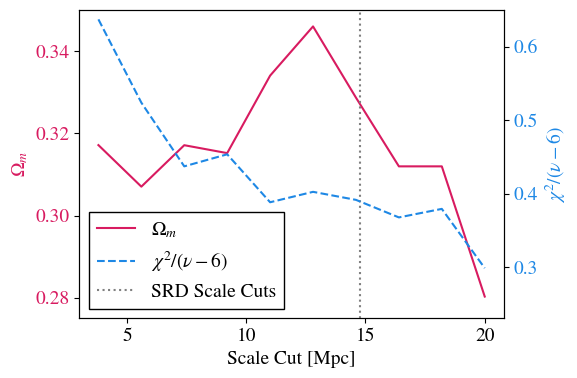

In [74]:
fig, ax1 = plt.subplots(figsize=(6, 4))

color = '#D81B60'
ax1.set_xlabel('Scale Cut [Mpc]')
ax1.set_ylabel('$\\Omega_m$', color=color)
ax1.plot((angles_to_try/1000)[1:], [res.x[0] for res in reslist][1:], color=color, label='$\\Omega_m$')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = '#1E88E5'
ax2.set_ylabel('$\\chi^2/(\\nu-6)$', color=color)  # we already handled the x-label with ax1
ax2.plot((angles_to_try/1000)[1:], np.divide(chi2_list, np.subtract(dof_list, 6))[1:], color=color, ls='--', label='$\\chi^2/(\\nu-6)$')
ax2.tick_params(axis='y', labelcolor=color)
ax2.vlines(txp_val, 0, 2, color='gray', ls=':', zorder=0, label='SRD Scale Cuts')
ax2.set_ylim(.23, .65)
ax1.set_ylim(.275, .35)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='lower left', fancybox=False, framealpha=1, edgecolor='0')

fig.tight_layout()
# plt.show()
plt.savefig('scale_cuts.png', dpi=300, format='png', bbox_inches='tight')

In [ ]:
data_vector[1]

Nz_0     z_0  Nz_1     z_1  Nz_2     z_2  Nz_3     z_3  Nz_4     z_4
0    0.0  0.0075   0.0  0.0075   0.0  0.0075   0.0  0.0075   0.0  0.0075
1    0.0  0.0225   0.0  0.0225   0.0  0.0225   0.0  0.0225   0.0  0.0225
2    0.0  0.0375   0.0  0.0375   0.0  0.0375   0.0  0.0375   0.0  0.0375
3    0.0  0.0525   0.0  0.0525   0.0  0.0525   0.0  0.0525   0.0  0.0525
4    0.0  0.0675   0.0  0.0675   0.0  0.0675   0.0  0.0675   0.0  0.0675
..   ...     ...   ...     ...   ...     ...   ...     ...   ...     ...
95   0.0  1.4325   0.0  1.4325   0.0  1.4325   0.0  1.4325   0.0  1.4325
96   0.0  1.4475   0.0  1.4475   0.0  1.4475   0.0  1.4475   0.0  1.4475
97   0.0  1.4625   0.0  1.4625   0.0  1.4625   0.0  1.4625   0.0  1.4625
98   0.0  1.4775   0.0  1.4775   0.0  1.4775   0.0  1.4775   0.0  1.4775
99   0.0  1.4925   0.0  1.4925   0.0  1.4925   0.0  1.4925   0.0  1.4925

[100 rows x 10 columns]